In [1]:
import os
import time
from collections import deque
from importlib import reload

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

import utilities

Features to add:
- add item_category, shop_id, and item_id as features
- encode these categorical vars: mean encode - HOW?
    - most successfull one in the homework was expanding mean scheme. - suggests I need lagged features too

- create a feature that bins shops into groups based on net income
    - perhaps net income by category of item
- create feature that bins shops into groups based on seasonal pattern (spectral biclustering?)
- similarly create a feature that groups products based on seasonal pattern
- need to add date indicators:
    * perhaps group months into high holiday/low holiday count
    * perhaps number of days in month
    * number of weekend days vs week days
- create features based on lagged behavior
    * rolling windows sum/variance (last 3 mos, last 6 months, last year)
    * can do this for each item, or can use this as an encoding of shop, and category ids


In [2]:
sales = utilities.load_and_preprocess()

# Pre processing

In [7]:
agg_sales = utilities.aggregate_monthly(sales)
piv_agg_sales = agg_sales.set_index(['Month', 'shop_id', 'item_id']).item_cnt_month.unstack(level=0).fillna(0)

In [14]:
stacked = piv_agg_sales.stack()

In [15]:
stacked[stacked !=0].describe()

count    1.606541e+06
mean     2.270845e+00
std      8.656355e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.253000e+03
dtype: float64

In [16]:
stacked.sort_values()

shop_id  item_id  Month  
12       8023     2013-11     -22.0
         1590     2013-01     -13.0
         1593     2013-01      -6.0
         11367    2014-08      -5.0
         3732     2013-11      -4.0
                              ...  
55       3730     2015-04    1242.0
31       20949    2013-12    1305.0
55       9249     2015-09    1644.0
12       9248     2015-09    1644.0
         11373    2015-10    2253.0
Length: 14420216, dtype: float64

In [17]:
preprocessed_data = np.clip(piv_agg_sales, 0, 20)

In [18]:
preprocessed_data.stack().sort_values()

shop_id  item_id  Month  
0        30       2013-01     0.0
41       17063    2015-02     0.0
                  2015-03     0.0
                  2015-04     0.0
                  2015-05     0.0
                             ... 
25       4084     2015-06    20.0
14       2308     2015-06    20.0
22       3329     2014-02    20.0
9        15284    2014-10    20.0
51       2814     2014-04    20.0
Length: 14420216, dtype: float64

# Feature generation

In [19]:
preprocessed_data.head()

Month            2013-01  2013-02  2013-03  2013-04  2013-05  2013-06  \
shop_id item_id                                                         
0       30           0.0     20.0      0.0      0.0      0.0      0.0   
        31           0.0     11.0      0.0      0.0      0.0      0.0   
        32           6.0     10.0      0.0      0.0      0.0      0.0   
        33           3.0      3.0      0.0      0.0      0.0      0.0   
        35           1.0     14.0      0.0      0.0      0.0      0.0   

Month            2013-07  2013-08  2013-09  2013-10  ...  2015-01  2015-02  \
shop_id item_id                                      ...                     
0       30           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        31           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        32           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        33           0.0      0.0      0.0      0.0  ...      0.0      0.0   
        35           0.0      0.0      0.0      0.0  ...      0.0      0.0   

Month            2015-03  2015-04  2015-05  2015-06  2015-07  2015-08  \
shop_id item_id                                                         
0       30           0.0      0.0      0.0      0.0      0.0      0.0   
        31           0.0      0.0      0.0      0.0      0.0      0.0   
        32           0.0      0.0      0.0      0.0      0.0      0.0   
        33           0.0      0.0      0.0      0.0      0.0      0.0   
        35           0.0      0.0      0.0      0.0      0.0      0.0   

Month            2015-09  2015-10  
shop_id item_id                    
0       30           0.0      0.0  
        31           0.0      0.0  
        32           0.0      0.0  
        33           0.0      0.0  
        35           0.0      0.0  

[5 rows x 34 columns]

In [23]:
target_encode_shops = preprocessed_data.groupby(level=0).transform('sum')
target_encode_items = preprocessed_data.groupby(level=1).transform('sum')

In [27]:
%%time
half_lifes = [3,6,9,12]
sales_ewms_mean = {tau:preprocessed_data.ewm(halflife=tau, axis=1, min_periods=tau).mean() for tau in half_lifes}
sales_ewms_std = {tau:preprocessed_data.ewm(halflife=tau, axis=1, min_periods=tau).std() for tau in half_lifes}
items_ewms = {tau:target_encode_items.ewm(halflife=tau, axis=1, min_periods=tau).mean() for tau in half_lifes}
shops_ewms = {tau:target_encode_shops.ewm(halflife=tau, axis=1, min_periods=tau).mean() for tau in half_lifes}

Wall time: 40.9 s


In [56]:
all_months = preprocessed_data.columns.tolist()
full_data_monts = all_months[11:-1]

In [33]:
sales_mean_features = {f'sales_ewms_mean_{tau}': sales_ewms_mean[tau] for tau in half_lifes}
sales_std_features = {f'sales_ewms_std_{tau}': sales_ewms_std[tau] for tau in half_lifes}
items_features = {f'items_ewms_{tau}': items_ewms[tau] for tau in half_lifes}
shops_features = {f'shops_ewms_{tau}': shops_ewms[tau] for tau in half_lifes}

features_dict = {**sales_mean_features, **sales_std_features, **items_features, **shops_features}

#### Define objective

In [33]:
# Note that I use raw-data for objective 
objectives = piv_agg_sales.shift(-1, axis=1)

In [34]:
def get_single_month_XY(month_):
    cols = [df[month_].rename(name) for (name, df) in features_dict.items()]
    X = pd.concat(cols, axis=1)
    Y = objectives[month_]
    
    # might turn this into separate function to pass into here
    X['month'] = month_.month
    X['season'] = X.month.map({1:0, 2:0, 3:0, 4:1, 5:1, 6:1, 7:1, 8:2, 9:2, 10:2, 11:3, 12:3})
    
    return X,Y

In [35]:
tempx, tempy = get_single_month_XY(all_months[-1])

In [36]:
tempx.head()

sales_ewms_mean_3  sales_ewms_mean_6  sales_ewms_mean_9  \
shop_id item_id                                                            
0       30                0.002539           0.055208           0.136002   
        31                0.001397           0.030364           0.074801   
        32                0.001874           0.042359           0.105777   
        33                0.000683           0.015659           0.039288   
        35                0.001878           0.041105           0.101497   

                 sales_ewms_mean_12  sales_ewms_std_3  sales_ewms_std_6  \
shop_id item_id                                                           
0       30                 0.205637          0.239550          1.082319   
        31                 0.113101          0.131752          0.595275   
        32                 0.161047          0.135807          0.621241   
        33                 0.059960          0.048122          0.222969   
        35                 0.153651          0.168023          0.759210   

                 sales_ewms_std_9  sales_ewms_std_12  items_ewms_3  \
shop_id item_id                                                      
0       30               1.681512           2.057318      5.540970   
        31               0.924832           1.131525     17.644985   
        32               0.968103           1.185516     25.616945   
        33               0.348919           0.428141     15.727999   
        35               1.179305           1.442581      0.039445   

                 items_ewms_6  items_ewms_9  items_ewms_12  shops_ewms_3  \
shop_id item_id                                                            
0       30          12.546831     19.465955      24.680470      1.284202   
        31          18.898858     21.894434      24.537345      1.284202   
        32          31.954147     37.574238      41.638636      1.284202   
        33          17.680996     19.279259      20.354499      1.284202   
        35           0.628753      1.517110       2.283658      1.284202   

                 shops_ewms_6  shops_ewms_9  shops_ewms_12  month  season  
shop_id item_id                                                            
0       30           29.37242     73.644359     112.353092     10       2  
        31           29.37242     73.644359     112.353092     10       2  
        32           29.37242     73.644359     112.353092     10       2  
        33           29.37242     73.644359     112.353092     10       2  
        35           29.37242     73.644359     112.353092     10       2

# Fitting and CV

In [40]:
def fit_and_predict(model, x_train, y_train, x_val = None):
    
    start_time = time.time()
    fitted_model = model.fit(x_train, y_train)
    fit_time = time.time() - start_time
    
    y_train_pred = fitted_model.predict(x_train)
    
    if x_val is not None:
        y_val_pred = fitted_model.predict(x_val)
    else:
        y_val_pred = None
        
    
    return fitted_model, y_train_pred, y_val_pred, fit_time
    

In [42]:
X_train,Y_train = get_single_month_XY(full_data_monts[0])
X_val,Y_val = get_single_month_XY(full_data_monts[1])

In [43]:
mod = RandomForestRegressor(n_estimators=50, max_depth=5, n_jobs=-1)
fitted, ytpred, yvpred, elapsed = fit_and_predict(mod, X_train,Y_train, X_val)
elapsed, mean_squared_error(Y_train, ytpred), mean_squared_error(Y_val, yvpred)

(22.080796718597412, 1.0092510768894847, 2.117453188206695)

In [44]:
import xgboost as xgb

class xgb_model:
    def __init__(self, num_boost_round, **params):
        self.params = {
            'num_boost_round': num_boost_round,
            'max_depth':6,
            'min_child_weight': 1,
            'eta':.3,
            'subsample': 1,
            'colsample_bytree': 1,
            'objective':'reg:squarederror',
        }
        self.params.update(params)
        self.fitted_model = None
       
    def fit(self, X, Y):
        dm_train = xgb.DMatrix(X,Y)
        self.fitted_model = xgb.train(self.params, dtrain=dm_train)
        return self
    
    def predict(self, X):
        assert self.fitted_model is not None, 'Must fit first'
        dm = xgb.DMatrix(X)
        return self.fitted_model.predict(dm)
    
    def feature_importances_(self):
        pass

In [45]:
mod = xgb_model(num_boost_round=100, max_depth=10, eta=0.1)
fitted, ytpred, yvpred, elapsed = fit_and_predict(mod, X_train,Y_train, X_val)
elapsed, mean_squared_error(Y_train, ytpred), mean_squared_error(Y_val, yvpred)

(1.7579388618469238, 2.1183627917487504, 2.717918544968455)

In [48]:
mod = xgb_model(num_boost_round=1000, max_depth=10, eta=0.2)
fitted, ytpred, yvpred, elapsed = fit_and_predict(mod, X_train,Y_train, X_val)
elapsed, mean_squared_error(Y_train, ytpred), mean_squared_error(Y_val, yvpred)

(1.7123210430145264, 0.8415828722335232, 2.2553677688339344)

In [49]:
def rolling_cross_validation(model, data_months_list, validate_months_num=None, num_stack_months=1, fit_final=False):
    Xs_deque = deque()
    Ys_deque = deque()
    
    for month in data_months_list[:num_stack_months]:
        X_, Y_ = get_single_month_XY(month)
        Xs_deque.append(X_)
        Ys_deque.append(Y_)
        
    if validate_months_num is None:
        validate_months_num = len(data_months_list) - num_stack_months
    else:
        validate_months_num = min(validate_months_num, len(data_months_list) - num_stack_months)
        
    
    fitted_models = {}
    in_sample_scores = {}
    oos_scores = {}
    loop_times = []
    
    for month in data_months_list[num_stack_months: num_stack_months + validate_months_num]:
        print(f'Working on: {month}')
        loop_start = time.time()
        X_train = pd.concat(Xs_deque)
        Y_train = pd.concat(Ys_deque)
        
        X_val, Y_val = get_single_month_XY(month)
        fitted, ytrain_pred, yval_pred, elapsed_time = fit_and_predict(model, X_train, Y_train, X_val)
        fitted_models[month] = fitted
        print(f'fit time: {elapsed_time}')
        
        in_sample_scores[month] = mean_squared_error(Y_train, ytrain_pred)
        oos_scores[month] = mean_squared_error(Y_val, yval_pred)
        
        Xs_deque.popleft()
        Ys_deque.popleft()
        
        Xs_deque.append(X_val)
        Ys_deque.append(Y_val)
        
        loop_end = time.time()
        loop_times.append(loop_end - loop_start)
    
    if fit_final:
        X_train = pd.concat(Xs_deque)
        Y_train = pd.concat(Ys_deque)
        fitted, ytrain_pred, yval_pred, elapsed_time = fit_and_predict(model, X_train, Y_train, X_val)
        fitted_models['FINAL'] = fitted
        in_sample_scores['FINAL'] = mean_squared_error(Y_train, ytrain_pred)
    
    
    return fitted_models, in_sample_scores, oos_scores, loop_times

In [57]:
#mod = RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=5)
mod = xgb_model(num_boost_round=100, max_depth=5, eta=0.2)
fitted_models, isscores, osscores, times = rolling_cross_validation(mod, full_data_monts[-18:], num_stack_months=12, fit_final=True)

Working on: 2015-04
[18:38:53] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
fit time: 68.1698489189148
Working on: 2015-05
[18:40:05] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
fit time: 67.37126970291138
Working on: 2015-06
[18:41:16] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
fit time: 76.31252646446228
Working on: 2015-07
[18:42:36] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
fit time: 53.673496723175

In [58]:
fitted_models

{Period('2015-04', 'M'): <__main__.xgb_model at 0x211a03416d8>,
 Period('2015-05', 'M'): <__main__.xgb_model at 0x211a03416d8>,
 Period('2015-06', 'M'): <__main__.xgb_model at 0x211a03416d8>,
 Period('2015-07', 'M'): <__main__.xgb_model at 0x211a03416d8>,
 Period('2015-08', 'M'): <__main__.xgb_model at 0x211a03416d8>,
 Period('2015-09', 'M'): <__main__.xgb_model at 0x211a03416d8>,
 'FINAL': <__main__.xgb_model at 0x211a03416d8>}

In [59]:
pd.Series(isscores)

2015-04    7.452411
2015-05    7.639567
2015-06    7.385297
2015-07    7.291850
2015-08    7.134455
2015-09    8.320865
FINAL      8.011939
dtype: float64

In [60]:
pd.Series(osscores)

2015-04     6.915826
2015-05     2.629407
2015-06     2.074343
2015-07     2.104886
2015-08    23.481216
2015-09    15.051673
Freq: M, dtype: float64

In [61]:
all_months[-1]

Period('2015-10', 'M')

In [62]:
X,Y = get_single_month_XY(all_months[-1])

In [63]:
X

sales_ewms_mean_3  sales_ewms_mean_6  sales_ewms_mean_9  \
shop_id item_id                                                            
0       30                0.002539           0.055208           0.136002   
        31                0.001397           0.030364           0.074801   
        32                0.001874           0.042359           0.105777   
        33                0.000683           0.015659           0.039288   
        35                0.001878           0.041105           0.101497   
...                            ...                ...                ...   
59      22154             0.000101           0.002459           0.006296   
        22155             0.000403           0.004918           0.009994   
        22162             0.702939           0.802237           0.748449   
        22164             0.312336           0.327895           0.297187   
        22167             0.008484           0.042011           0.065287   

                 sales_ewms_mean_12  sales_ewms_std_3  sales_ewms_std_6  \
shop_id item_id                                                           
0       30                 0.205637          0.239550          1.082319   
        31                 0.113101          0.131752          0.595275   
        32                 0.161047          0.135807          0.621241   
        33                 0.059960          0.048122          0.222969   
        35                 0.153651          0.168023          0.759210   
...                             ...               ...               ...   
59      22154              0.009705          0.010671          0.051086   
        22155              0.013725          0.021339          0.072158   
        22162              0.697676          1.853619          2.045648   
        22164              0.273055          0.657870          0.668447   
        22167              0.078871          0.111351          0.247915   

                 sales_ewms_std_9  sales_ewms_std_12  items_ewms_3  \
shop_id item_id                                                      
0       30               1.681512           2.057318      5.540970   
        31               0.924832           1.131525     17.644985   
        32               0.968103           1.185516     25.616945   
        33               0.348919           0.428141     15.727999   
        35               1.179305           1.442581      0.039445   
...                           ...                ...           ...   
59      22154            0.080920           0.099967      3.301549   
        22155            0.101763           0.118640      0.324841   
        22162            2.009103           1.960133     32.395203   
        22164            0.643753           0.622845     24.478139   
        22167            0.307600           0.337109     33.641460   

                 items_ewms_6  items_ewms_9  items_ewms_12  shops_ewms_3  \
shop_id item_id                                                            
0       30          12.546831     19.465955      24.680470      1.284202   
        31          18.898858     21.894434      24.537345      1.284202   
        32          31.954147     37.574238      41.638636      1.284202   
        33          17.680996     19.279259      20.354499      1.284202   
        35           0.628753      1.517110       2.283658      1.284202   
...                       ...           ...            ...           ...   
59      22154        2.236950      1.893137       1.765641    985.970013   
        22155        0.655660      0.988987       1.224326    985.970013   
        22162       34.569629     31.654702      29.250980    985.970013   
        22164       25.276690     23.055133      21.285375    985.970013   
        22167       37.060915     38.214931      38.521178    985.970013   

                 shops_ewms_6  shops_ewms_9  shops_ewms_12  month  season  
shop_id item_id                                                            


In [64]:
predictions = fitted_models['FINAL'].predict(X)

In [65]:
predictions = pd.DataFrame({'item_cnt_month':predictions}, index=X.index)

In [66]:
utilities.merge_pred_with_test(predictions).to_csv('2020_08_25_month_stacked_xgb_with_ewms.csv')

# Analysis

In [105]:
def plot_feature_importances(mod, col_names, figsize=(6,10)):
    plt.figure(figsize=figsize)
    pd.Series(mod.feature_importances_, index=col_names).sort_values().plot(kind='barh')

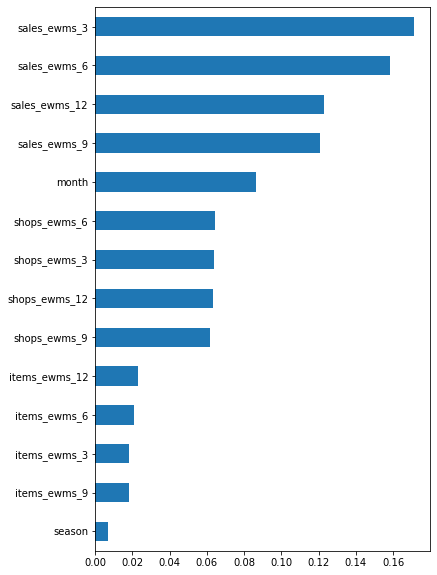

In [106]:
plot_feature_importances(fitted_models['FINAL'], X_train.columns)

Other code